In [1]:
import os
import re
from glob import glob
from tqdm import tqdm
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
fnames = glob('../input/train_simplified/*.csv')
cnames = ['countrycode', 'drawing', 'key_id', 'recognized', 'timestamp', 'word']
drawlist = []
for f in fnames[0:6]:
    first = pd.read_csv(f, nrows=10) # make sure we get a recognized drawing
    first = first[first.recognized==True].head(2)
    drawlist.append(first)
draw_df = pd.DataFrame(np.concatenate(drawlist), columns=cnames)
draw_df

,countrycode,drawing,key_id,recognized,timestamp,word
0,US,"[[[92, 91, 82, 69, 64, 56, 28, 15, 6, 0, 1, 18...",4745881255411712,True,2017-03-10 13:46:31.635970,sleeping bag
1,AU,"[[[4, 3, 11, 22, 38, 63, 251, 255, 251, 252, 2...",4573190200229888,True,2017-03-17 06:36:27.083520,sleeping bag
2,GB,"[[[28, 110, 126, 106, 59, 37, 32, 25], [168, 1...",5546137161302016,True,2017-03-29 12:39:34.815400,house plant
3,GB,"[[[60, 60, 62, 69, 98, 116, 169, 171, 157, 152...",6020882763874304,True,2017-03-03 12:09:53.163390,house plant
4,BR,"[[[48, 119, 208, 222, 228, 209, 175, 80, 25, 7...",4801185506656256,True,2017-01-26 00:40:23.964940,bathtub
5,GB,"[[[17, 230], [138, 136]], [[1, 8, 21, 33, 55, ...",5242011433041920,True,2017-03-21 19:08:39.365000,bathtub
6,US,"[[[4, 0, 2], [202, 98, 24]], [[1, 12, 10, 25, ...",5223042911305728,True,2017-03-18 02:52:34.909590,key
7,GB,"[[[36, 25, 9, 0, 0, 15, 30, 75, 90, 95, 97, 84...",5425151371902976,True,2017-03-04 09:29:43.337260,key
8,US,"[[[69, 32, 19, 7, 0, 18, 55, 86, 145, 196, 209...",4848879067463680,True,2017-03-06 15:00:27.328800,triangle
9,US,"[[[98, 48, 0], [0, 108, 235]], [[100, 133, 171...",5548323891052544,True,2017-01-27 12:47:55.869040,triangle


In [3]:
evens = range(0,11,2)
odds = range(1,12, 2)
df1 = draw_df[draw_df.index.isin(evens)]
df2 = draw_df[draw_df.index.isin(odds)]

example1s = [ast.literal_eval(pts) for pts in df1.drawing.values]
example2s = [ast.literal_eval(pts) for pts in df2.drawing.values]

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


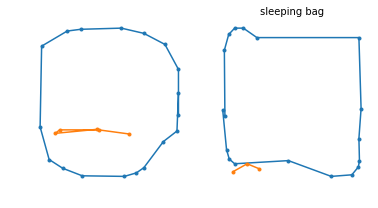

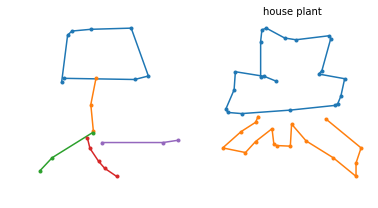

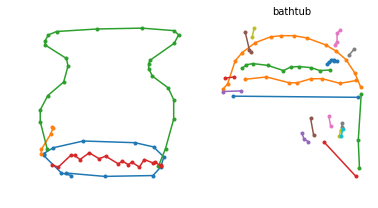

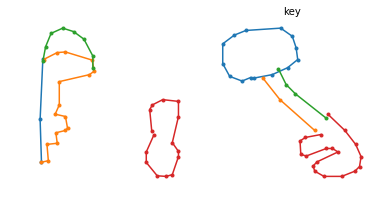

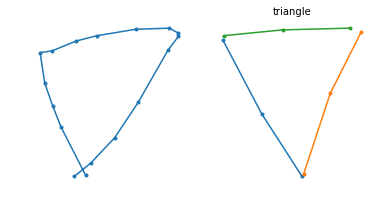

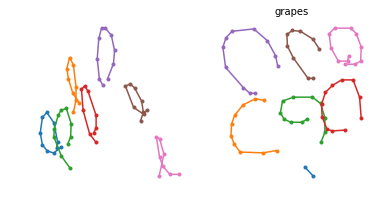

In [4]:
labels = df2.word.tolist()
for i, example in enumerate(example1s):
    plt.figure(figsize=(6,3))
    
    for x,y in example:
        plt.subplot(1,2,1)
        plt.plot(x, y, marker='.')
        plt.axis('off')

    for x,y, in example2s[i]:
        plt.subplot(1,2,2)
        plt.plot(x, y, marker='.')
        plt.axis('off')
        label = labels[i]
        plt.title(label, fontsize=10)

    plt.show()

In [5]:
# # commenting this out to save memory
# import urllib

# data_dir = './'
# model_dir = './'
# LABELS = np.array(['baseball', 'bowtie', 'clock', 'hand', 'hat'])
# num_classes = len(LABELS)
# ims_per_class = 10
# for b in tqdm(LABELS):
#     url = "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/{}.npy".format(b)
#     urllib.request.urlretrieve(url, "{}.npy".format(b))
# print(glob('./*.npy'))
# nb = np.load("{}.npy".format(b))
# print("\n Class '{0}' has {1} examples of {2}x{2} images".format(b, nb.shape[0], int(nb.shape[1]**0.5)))
# del nb

Convolutional Neural Network (CNN)
Next we'll build an image classifier. There are some resources in the repository I mentioned earlier showing how people have used the data. One of those resources is a CNN just like what you see here.

The biggest usage of resources seems to be converting the drawings to images. You can stick with a stroke-based model or go down the conversion path. Going that way requires watching data usage and managing space limits - deep learning on Kaggle can be like building a ship in a bottle:)

In [6]:
#%% import
import os
from glob import glob
import re
import ast
import numpy as np 
import pandas as pd
from PIL import Image, ImageDraw 
import urllib
from tqdm import tqdm
from dask import bag
from dask.diagnostics import ProgressBar
# ProgressBar().register()
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

#%% set global vars and params
class_files = os.listdir('../input/train_simplified/')
class_dict = {x[:-4].replace(" ", "_"):i for i, x in enumerate(class_files)}
reverse_dict = {v: k for k, v in class_dict.items()}

class_fraction = 1                     ## 
img_rows, img_cols = 32, 32              ##
ims_per_class = 1400                      ##

num_classes = int(len(class_files)*class_fraction)

In [7]:
# faster conversion function
def draw_it(strokes):
    image = Image.new("P", (256,256), color=255)
    image_draw = ImageDraw.Draw(image)
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0])-1):
            image_draw.line([stroke[0][i], 
                             stroke[1][i],
                             stroke[0][i+1], 
                             stroke[1][i+1]],
                            fill=0, width=5)
    image = image.resize((img_rows, img_cols))
    return np.array(image)/255.

#%% get train arrays
train_grand = []
class_paths = glob('../input/train_simplified/*.csv')
for i,c in enumerate(tqdm(class_paths[0: num_classes])):
    train = pd.read_csv(c, usecols=['word', 'drawing', 'recognized'], nrows=int(ims_per_class*4/3))
    train = train[train.recognized == True].head(ims_per_class)
    train['word'] = train.word.str.replace(" ", "_")
    imagebag = bag.from_sequence(train.drawing.values).map(draw_it) 
    trainarray = np.array(imagebag.compute())  # PARALLELIZE
    trainarray = np.reshape(trainarray, (ims_per_class, -1))    
    labelarray = train.word.map(class_dict).values
    labelarray = np.expand_dims(labelarray, 1)
    trainarray = np.concatenate((labelarray, trainarray), axis=1)
    train_grand.append(trainarray)
    
train_grand = np.array([train_grand.pop() for i in np.arange(num_classes)])

100%|██████████| 340/340 [06:12<00:00,  1.10s/it]


In [8]:
train_grand = train_grand.reshape((-1, (img_rows*img_cols+1)))
del trainarray
del train

In [9]:
x_train, x_val, y_train, y_val = train_test_split(train_grand[:,1:], train_grand[:, 0], 
                                        test_size=0.1, random_state=2)
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 1)
y_train_onehot = keras.utils.to_categorical(y_train, num_classes)
y_val_onehot = keras.utils.to_categorical(y_val, num_classes)

print(x_train.shape, "\n",
      y_train_onehot.shape, "\n",
      x_val.shape, "\n",
      y_val_onehot.shape)

(428400, 32, 32, 1) 
 (428400, 340) 
 (47600, 32, 32, 1) 
 (47600, 340)


In [10]:
del train_grand

In [11]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(img_rows, img_cols, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(680, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 680)               2785960   
__________

In [12]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(x_train, y_train_onehot,
          batch_size = 32,
          epochs = 8,
          validation_data=(x_val, y_val_onehot),
          verbose = 2)

score = model.evaluate(x_val, y_val_onehot, verbose = 1)
print("\nAccuracy {}".format(score[1]))

Train on 428400 samples, validate on 47600 samples
Epoch 1/8
 - 1061s - loss: 3.3324 - acc: 0.2718 - val_loss: 2.3413 - val_acc: 0.4464
Epoch 2/8
 - 1065s - loss: 2.6304 - acc: 0.3798 - val_loss: 2.1393 - val_acc: 0.4801
Epoch 3/8
 - 1066s - loss: 2.4676 - acc: 0.4107 - val_loss: 2.0568 - val_acc: 0.5032
Epoch 4/8
 - 1060s - loss: 2.3836 - acc: 0.4257 - val_loss: 2.0243 - val_acc: 0.5067
Epoch 5/8
 - 1066s - loss: 2.3217 - acc: 0.4373 - val_loss: 1.9967 - val_acc: 0.5150
Epoch 6/8
 - 1072s - loss: 2.2842 - acc: 0.4448 - val_loss: 1.9626 - val_acc: 0.5203
Epoch 7/8
 - 1071s - loss: 2.2549 - acc: 0.4510 - val_loss: 1.9524 - val_acc: 0.5220
Epoch 8/8
 - 1072s - loss: 2.2283 - acc: 0.4561 - val_loss: 1.8894 - val_acc: 0.5316
47600/47600 [==============================] - 28s 582us/step

Accuracy 0.5315546218487395


In [13]:
del x_train

In [14]:
#%% get test set
ttvlist = []
reader = pd.read_csv('../input/test_simplified.csv', index_col=['key_id'],
    chunksize=2048)
for chunk in tqdm(reader):
    imagebag = bag.from_sequence(chunk.drawing.values).map(draw_it)
    testarray = np.array(imagebag.compute())
    testarray = np.reshape(testarray, (testarray.shape[0], img_rows, img_cols, 1))
    testpreds = model.predict(testarray, verbose=0)
    ttvs = np.argsort(-testpreds)[:, 0:3]  # top 3
    ttvlist.append(ttvs)
    
ttvarray = np.concatenate(ttvlist)

55it [02:11,  2.40s/it]


In [15]:
preds_df = pd.DataFrame({'first': ttvarray[:,0], 'second': ttvarray[:,1], 'third': ttvarray[:,2]})
preds_df = preds_df.replace(reverse_dict)
preds_df['words'] = preds_df['first'] + " " + preds_df['second'] + " " + preds_df['third']

sub = pd.read_csv('../input/sample_submission.csv', index_col=['key_id'])
sub['word'] = preds_df.words.values
sub.to_csv('submission.csv')
sub.head()

,word
key_id,
9000003627287624,radio motorbike stereo
9000010688666847,hockey_puck belt sandwich
9000023642890129,The_Great_Wall_of_China castle fence
9000038588854897,mountain tent triangle
9000052667981386,campfire harp fireplace
